![Logo dell'Università XYZ](img/logo.jpg)

# Advanced Financial Modeling Course

## Introduction

This notebook is part of the teaching material of the Advanced Financial Modeling course! In this series of Jupyter notebooks, we will cover various topics related to financial modeling, including fundamental concepts, practical applications, and hands-on exercises.

### Notebooks Overview

1. [Notebook 1: Curve Building](notebooks/notebook1.ipynb)
2. [Notebook 2: AAD-Greeks](notebooks/notebook2.ipynb)
3. [Notebook 3: Swap AAD Sensitivities](notebooks/notebook3.ipynb)
3. [Notebook 4: Simulation of Extended Short-Rate Models](notebooks/notebook3.ipynb)
4. [Notebook 5: Model Calibration](notebooks/notebook4.ipynb)
5. [Notebook 6: SABR stochastic volatility](notebooks/notebook5.ipynb)
5. [Notebook 7: xVA--CCR simulation](notebooks/notebook5.ipynb)


## Notebook 7: xVA--CCR simulation 

In this notebook, we'll explore techniques for simulating xVA (Valuation Adjustments) with a specific focus on Credit Valuation Adjustment (CVA) and Counterparty Credit Risk (CCR). We'll provide a practical example tailored to the EUR market context.

### Topics Covered

- Importing market data and trade details for xVA calculation.
- Defining simulation inputs, including market scenarios and time grid.
- Generating exposure paths using a short-rate model for interest rate derivatives.
- Aggregating simulation results to compute xVA metrics.

In [1]:
import QuantLib as ql
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

## market import

In [2]:
def get_estr(Market_DFs):
    df = Market_DFs[Market_DFs['Property'].str.contains("IR.EUR-ESTR-ON.DF")][['Property', 'Label']]
    date_format = '%d-%b-%Y'
    dates_QuantLib = []
    for i in range(len(df['Property'].values)):
        str_temp = df['Property'].values[i][18:29]
        datetime_obj = datetime.strptime(str_temp, date_format)
        dates_QuantLib.append(ql.Date.from_date(datetime_obj))

    DFs = df['Label'].values

    yieldTermStructure = ql.DiscountCurve(dates_QuantLib, DFs, ql.Actual360(), ql.TARGET())
    yieldTermStructure.enableExtrapolation()
    return yieldTermStructure

#################################### EUR6M
def get_eur6m(Market_DFs):
    df = Market_DFs[Market_DFs['Property'].str.contains("IR.EUR-EURIBOR-6M.DF")][['Property', 'Label']]
    date_format = '%d-%b-%Y'
    dates_str = []
    dates_datetime = []
    dates_QuantLib = []
    for i in range(len(df['Property'].values)):
        str_temp = df['Property'].values[i][21:32]
        datetime_obj = datetime.strptime(str_temp, date_format)
        dates_QuantLib.append(ql.Date.from_date(datetime_obj))

    DFs = df['Label'].values

    yieldTermStructure = ql.DiscountCurve(dates_QuantLib, DFs, ql.Actual360(), ql.TARGET())
    yieldTermStructure.enableExtrapolation()
    return yieldTermStructure


In [4]:
market_data = pd.read_csv('data/Market_2023_09_29_DFs.csv', 
                            skiprows= 2,
                            on_bad_lines='skip')

############### market ###############  
marketCurve = get_estr(market_data)
forecastingCurve_t0 = get_eur6m(market_data)
forecastingCurve = ql.RelinkableYieldTermStructureHandle(forecastingCurve_t0)
index_eur6m = ql.Euribor6M(forecastingCurve)

calendar = ql.TARGET()
evaluation_date = marketCurve.referenceDate()
ql.Settings.instance().evaluationDate = evaluation_date
settlement_date = calendar.advance(evaluation_date, ql.Period('2D'))

## portfolio import

In [5]:
def custom_swap(index):
    ## SWAP ATLANDES 0-17092454
    swapType = ql.VanillaSwap.Receiver
    custom_schedule = ql.MakeSchedule(ql.Date(31,12,2015), ql.Date(31,12,2040), ql.Period('6M'))
    fixed_rate = [0.04156]*(len(custom_schedule)-1)
    notional = [143857602,142099704,140995554,139343227,138170625,136487409,135100610,133235348,131633135,130088055,
     128443001,126527961,124478813,122046073,119540895,117334856,115325682,113682288,112374057,110400222,108996590,
     107427609,106277787,104934949,103826978,102318265,101011839,99241108,97427949,95062460,92643968,89488286,86306759,
     82654668,79233393,75249260,71491885,67239725,63147273,58562602,54101515,49235670,44484930,39276217,34122360,28587822,
     23186787,17327243,11581997,5627771]

    fixedDayCount = ql.Actual360()
    floatDayCount = ql.Actual360()

    factor = [1.] *(len(custom_schedule)-1)
    margin = [0.] *(len(custom_schedule)-1)

    nonstandardSwap = ql.NonstandardSwap(swapType,
                                         notional, notional,
                                        custom_schedule, fixed_rate, fixedDayCount,
                                        custom_schedule, index, 
                                         factor, margin, floatDayCount)
    return nonstandardSwap

In [6]:
############### trade ############### 
custom_trade = custom_swap(index_eur6m)
firstIndexFixing  = 0.04

## static simulation data

In [7]:
# class for hosting simulation grid (dates, times)
class Grid:
    def __init__(self, startDate, endDate, tenor):
        # create date schedule, ignore conventions and calendars
        self.schedule = ql.Schedule(startDate, endDate, tenor, ql.NullCalendar(), 
            ql.Unadjusted, ql.Unadjusted, ql.DateGeneration.Forward, False)
        self.dayCounter = ql.Actual365Fixed()
        self.tenor = tenor
    def GetDates(self):
        # get list of scheduled dates
        dates = []
        [dates.append(self.schedule[i]) for i in range(self.GetSize())]
        return dates            
    def GetTimes(self):
        # get list of scheduled times
        times = []
        [times.append(self.dayCounter.yearFraction(self.schedule[0], self.schedule[i])) 
            for i in range(self.GetSize())]
        return times
    def GetMaturity(self):
        # get maturity in time units
        return self.dayCounter.yearFraction(self.schedule[0], self.schedule[self.GetSteps()])
    def GetSteps(self):
        # get number of steps in schedule
        return self.GetSize() - 1    
    def GetSize(self):
        # get total number of items in schedule
        return len(self.schedule)    
    def GetTimeGrid(self):
        # get QuantLib TimeGrid object, constructed by using list of scheduled times
        return ql.TimeGrid(self.GetTimes(), self.GetSize())
    def GetDt(self):
        # get constant time step
        return self.GetMaturity() / self.GetSteps()
    def GetTenor(self):
        # get grid tenor
        return self.tenor

In [8]:
############### simulation ############### 
simulationEndDate = evaluation_date + ql.Period("20Y")
gridStepPeriod = ql.Period(3, ql.Months)
ql.Settings.instance().evaluationDate = evaluation_date
grid = Grid(evaluation_date, simulationEndDate, gridStepPeriod)
times = grid.GetTimes()
dates = grid.GetDates()
times = grid.GetTimes()
dates = grid.GetDates()

## simulation

In [9]:
def GeneratePaths(process, timeGrid, Npaths):
    
    timestep_len= len(timeGrid[1:])
    dimension = process.factors()
    gen_paths = np.zeros((dimension, timestep_len+1, Npaths))

    rng = ql.UniformRandomSequenceGenerator(dimension * timestep_len, ql.UniformRandomGenerator())
    sequenceGenerator = ql.GaussianRandomSequenceGenerator(rng)
    pathGenerator = ql.GaussianMultiPathGenerator(process, list(timeGrid), sequenceGenerator, False)

    # paths[0] contiene il primo fattore simulato, paths[1] contiene il secondo, se esiste (es. vola)
    paths = [[] for i in range(dimension)]
    for i in range(Npaths):
        samplePath = pathGenerator.next()
        values = samplePath.value() 

        for j in range(dimension):
            gen_paths[j, :, i] = values[0]
    return gen_paths[0,:,:].T
# workhorse: simulate future exposures for a given transaction using HW1F process
def CalculateExposures_HW(a, sigma, rateTermStructure, forecastingCurve, index, latestIndexFixing, transaction, grid, nPaths):
    times = np.array(grid.GetTimes())
    dates = np.array(grid.GetDates())

    # request Hull-White 1-factor process and calibrated model parameters
    # generate paths for short rate
    #process, a, sigma = CreateStochasticProcess(rateTermStructure)
    #paths = GeneratePaths(process, grid.GetTimeGrid(), nPaths)
    #rateTermStructure = CreateYieldTermStructure()
    process = ql.HullWhiteProcess(ql.YieldTermStructureHandle(rateTermStructure), a, sigma)
    model = ql.HullWhite(ql.YieldTermStructureHandle(rateTermStructure), a, sigma)

    paths = GeneratePaths(process, times, nPaths)

    # request transaction floating leg fixings dates
    scheduleDates = np.array(list(transaction.floatingSchedule()))
    transactionFixingDates = np.array([index.fixingDate(scheduleDates[i]) for i in range(scheduleDates.shape[0])])
    transactionFixingRates = np.zeros(shape = (transactionFixingDates.shape[0]))

    # create fixing dates, request simulated fixings
    # correction for the first observed fixing
    simulatedFixingDates = np.array(dates) - ql.Period(index.fixingDays(), ql.Days)
    simulatedFixingRates = np.mean(paths[:], axis = 0)
    simulatedFixingRates[0] = latestIndexFixing

    # create fixings lookup table
    fixingsLookupTable = {}
    for i in range(simulatedFixingDates.shape[0]):
        fixingsLookupTable[simulatedFixingDates[i]] = simulatedFixingRates[i]

    # add transaction fixing rates for a given date from fixings lookup table
    for i in range(transactionFixingDates.shape[0]):
        if transactionFixingDates[i] in fixingsLookupTable:
            transactionFixingRates[i] = fixingsLookupTable[transactionFixingDates[i]]
        else:
            # find the nearest fixing from lookup table
            transactionFixingRates[i] = \
            fixingsLookupTable.get(transactionFixingDates[i], \
            fixingsLookupTable[min(fixingsLookupTable.keys(), \
            key = lambda d: abs(d - transactionFixingDates[i]))])

    # add required transaction fixing dates and rates to floating leg index
    index.addFixings(transactionFixingDates, transactionFixingRates, True)

    # create containers for simulated curves and exposures
    curves = np.zeros(shape = (nPaths, grid.GetSize()), dtype = ql.DiscountCurve)
    exposures = np.zeros(shape = (nPaths, grid.GetSize()), dtype = float)
    # set the first curve to be current spot market curve
    curves[:, 0] = rateTermStructure


    # loop through time steps
    for t in range(1, grid.GetSteps()):
        # loop through all paths        
        for s in range(nPaths):
            curveDate = dates[t]
            rt = paths[s, t]

            curveDates = [curveDate]
            curveDates += [curveDate + ql.Period(i, ql.Days) for i in range(1, 5)]
            curveDates += [curveDate + ql.Period(i, ql.Weeks) for i in range(1, 3)]
            curveDates += [curveDate + ql.Period(i, ql.Months) for i in range(1, 12)]
            curveDates += [curveDate + ql.Period(i, ql.Years) for i in range(1, 15)]
            curveDates += [curveDate + ql.Period(i, ql.Years) for i in [20,25,30,40]]
            curveTaus = [ql.ActualActual().yearFraction(curveDate, d) for d in curveDates]

            zeros = np.ones(len(curveDates))
            for k in range(1, len(curveDates)):
                zeros[k] = model.discountBond(times[t], times[t]+ curveTaus[k], rt)

            # create a new curve from simulated zero-coupon bond prices
            curves[s, t] = ql.DiscountCurve(curveDates, zeros, ql.Actual360(), ql.TARGET())
            curves[s, t].enableExtrapolation()

    # link transaction and pricing engine
    discountingCurve = ql.RelinkableYieldTermStructureHandle()
    swapEngine = ql.DiscountingSwapEngine(discountingCurve)
    transaction.setPricingEngine(swapEngine)

    # loop through grid time steps
    for t in range(grid.GetSteps()):
        # move forward in time along the grid
        ql.Settings.instance().evaluationDate = dates[t]
        # calculate pv for transaction
        # link discounting and forecasting curves to a simulated curve
        for s in range(nPaths):
            curve = curves[s][t]
            discountingCurve.linkTo(curve)
            forecastingCurve.linkTo(curve)
            # save pv to exposure matrix
            exposures[s][t] = transaction.NPV()   
    return exposures


def xvaAggregations(exposures, grid, DTS_ctpy, DTS_own, recoveryRate):
    ###### AGGREGATIONS
    # calculate expected positive and negative exposures
    positiveExposures = exposures.copy()
    positiveExposures[positiveExposures < 0.0] = 0.0
    EPE = np.mean(positiveExposures, axis = 0)

    negativeExposures = exposures.copy()
    negativeExposures[negativeExposures > 0.0] = 0.0
    ENE = np.mean(negativeExposures, axis = 0)


    # calculations for selected XVA metrics from simulated exposures
    cvaTerms = 0.0
    dvaTerms = 0.0
    for i in range(grid.GetSteps()):
        df = marketCurve.discount(times[i + 1])
        dPD_ctpy = DTS_ctpy.defaultProbability(times[i + 1]) - DTS_ctpy.defaultProbability(times[i])
        dPD_own = DTS_own.defaultProbability(times[i + 1]) - DTS_own.defaultProbability(times[i])
        cvaTerms += df * 0.5 * (EPE[i + 1] + EPE[i]) * dPD_ctpy
        dvaTerms += df * 0.5 * (ENE[i + 1] + ENE[i]) * dPD_own

    CVA = (1.0 - recoveryRate) * cvaTerms
    DVA = (1.0 - recoveryRate) * dvaTerms
    return CVA, DVA, EPE, ENE


In [10]:
a = 0.142184283416318
sigma = 0.008135596903654983
nPaths = 2048
exposures = CalculateExposures_HW(a, sigma, marketCurve, forecastingCurve, index_eur6m,
                                  firstIndexFixing, custom_trade, grid, nPaths)

In [11]:
pd_dates =  [evaluation_date + ql.Period(i, ql.Years) for i in range(11)]
pdcurve = [0.02 * i for i in range(11)] # pd curve 

DTS_ctpy = ql.HazardRateCurve(pd_dates,pdcurve,ql.Actual365Fixed())
DTS_own = ql.HazardRateCurve(pd_dates,pdcurve,ql.Actual365Fixed())
DTS_ctpy.enableExtrapolation()
DTS_own.enableExtrapolation()

In [12]:
recoveryRate = 0.4
CVA, DVA, EPE, ENE = xvaAggregations(exposures, grid, DTS_ctpy, DTS_own, recoveryRate)

DTS_ctpy.enableExtrapolation()
DTS_own.enableExtrapolation()

# print PV and XVA results
print('PV = ' + str(round(exposures[0][0], 0)))
print('Pre-margin uCVA = ' + str(round(CVA, 0)))
print('Pre-margin uDVA = ' + str(round(DVA, 0)))

PV = 10164195.0
Pre-margin uCVA = 2228504.0
Pre-margin uDVA = -94466.0


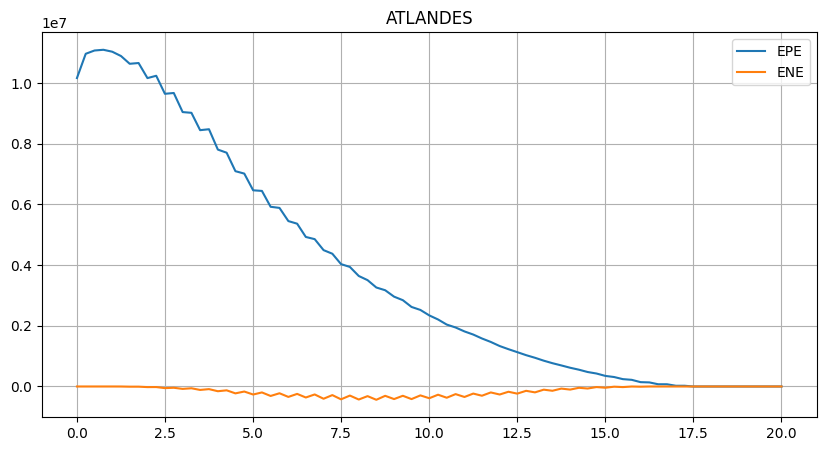

In [13]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.plot(times, EPE.T, label = "EPE")
plt.plot(times, ENE.T, label = "ENE")
plt.title('ATLANDES')
plt.legend()
plt.grid()
plt.show()